# Steering Faithfulness Sandbox

Testing out functions, playing around with code. Sometimes plotting results, too.

In [15]:
import pickle
import matplotlib.pyplot as plt
import json
import re

In [16]:
hint_filtered = []

# Go through results with normal and hinted prompting
# Collect all questions where the presence of the hint changes the model answer from incorrect to correct
for dataset in ['MMLU-Pro-math']: #['gsm8k', 'MATH-500', 'AIME2024', 'gpqa', 'AIME2025', 'MMLU-Pro-math']:
    with open(f"../src/normal_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        normal_results = json.load(f)

    with open(f"../src/hint_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        hint_results = json.load(f)

    incor_to_cor = []
    normal_recs = normal_results['runs'][0]['records']
    hint_recs = hint_results['runs'][0]['records']
    reasoning_length = 15000

    # Filtering for reasoning length to ensure we don't just include questions where the model never completed its answer
    for index, question in enumerate(normal_recs):
        if not question['correct'] and hint_recs[index]['correct'] and question['reasoning_length'] < reasoning_length and str(question['prediction']).split("\\%")[0] != question['gold']:
            incor_to_cor.append(index)

    for index in incor_to_cor:
        hint_filtered.append(hint_recs[index])

In [19]:
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
acc_results = {}

for alpha in alphas:
    for layer in [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]:
        if alpha == 0.0 and layer in [10, 12, 14, 16, 20, 22, 24, 26, 28]:
            acc_results[f"{alpha}_{layer}"] = [0.925531914893617, 94]
            continue
        with open(f'../results/steered_gens/deepseek-llama3-8b/MMLU-Pro-Math/l{layer}_{alpha}_gen.json', 'rb') as file:
            steered_ans = json.load(file)
        
        answered = 0
        correct = 0
        
        for index, question in enumerate(hint_filtered):
            match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
            if not match:
                continue
            else:
                answered += 1
                if match.group(1) == hint_filtered[index]['gold']:
                    correct += 1
        
        accuracy = correct / answered
        acc_results[f"{alpha}_{layer}"] = [accuracy, answered]

In [20]:
acc_results

{'0.0_10': [0.925531914893617, 94],
 '0.0_12': [0.925531914893617, 94],
 '0.0_14': [0.925531914893617, 94],
 '0.0_16': [0.925531914893617, 94],
 '0.0_18': [0.925531914893617, 94],
 '0.0_20': [0.925531914893617, 94],
 '0.0_22': [0.925531914893617, 94],
 '0.0_24': [0.925531914893617, 94],
 '0.0_26': [0.925531914893617, 94],
 '0.0_28': [0.925531914893617, 94],
 '0.25_10': [0.95, 100],
 '0.25_12': [0.9393939393939394, 99],
 '0.25_14': [0.9340659340659341, 91],
 '0.25_16': [0.9010989010989011, 91],
 '0.25_18': [0.898989898989899, 99],
 '0.25_20': [0.9263157894736842, 95],
 '0.25_22': [0.9052631578947369, 95],
 '0.25_24': [0.9019607843137255, 102],
 '0.25_26': [0.9354838709677419, 93],
 '0.25_28': [0.9340659340659341, 91],
 '0.5_10': [0.9263157894736842, 95],
 '0.5_12': [0.9213483146067416, 89],
 '0.5_14': [0.9247311827956989, 93],
 '0.5_16': [0.9148936170212766, 94],
 '0.5_18': [0.8958333333333334, 96],
 '0.5_20': [0.9489795918367347, 98],
 '0.5_22': [0.9375, 96],
 '0.5_24': [0.945054945054

In [23]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/steering_results_start.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [24]:
steering_results

{'l22_0.25_gen': 0.6524822695035462,
 'l18_0.5_gen': 0.6382978723404256,
 'l16_0.5_gen': 0.6312056737588653,
 'l26_0.75_gen': 0.6737588652482269,
 'l10_0.5_gen': 0.6879432624113475,
 'l24_0.75_gen': 0.6737588652482269,
 'l22_0.75_gen': 0.6808510638297872,
 'l10_0.25_gen': 0.7021276595744681,
 'l24_0.25_gen': 0.6312056737588653,
 'l18_0.75_gen': 0.624113475177305,
 'l14_0.5_gen': 0.7021276595744681,
 'l26_0.25_gen': 0.6453900709219859,
 'l18_1.0_gen': 0.6382978723404256,
 'l12_0.25_gen': 0.6595744680851063,
 'l18_0.0_gen': 0.6170212765957447,
 'l28_1.0_gen': 0.6879432624113475,
 'l14_0.25_gen': 0.6879432624113475,
 'l24_0.5_gen': 0.6950354609929078,
 'l24_1.0_gen': 0.7021276595744681,
 'l20_1.0_gen': 0.6453900709219859,
 'l10_1.0_gen': 0.6382978723404256,
 'l16_1.0_gen': 0.6312056737588653,
 'l14_0.75_gen': 0.6950354609929078,
 'l18_0.25_gen': 0.6382978723404256,
 'l16_0.75_gen': 0.6453900709219859,
 'l16_0.25_gen': 0.6666666666666666,
 'l28_0.5_gen': 0.6453900709219859,
 'l12_0.75_gen'

In [25]:
ff_10 = [steering_results['l18_0.0_gen'], steering_results['l10_0.25_gen'], steering_results['l10_0.5_gen'], steering_results['l10_0.75_gen'], steering_results['l10_1.0_gen']]
ff_12 = [steering_results['l18_0.0_gen'], steering_results['l12_0.25_gen'], steering_results['l12_0.5_gen'], steering_results['l12_0.75_gen'], steering_results['l12_1.0_gen']]
ff_14 = [steering_results['l18_0.0_gen'], steering_results['l14_0.25_gen'], steering_results['l14_0.5_gen'], steering_results['l14_0.75_gen'], steering_results['l14_1.0_gen']]
ff_16 = [steering_results['l18_0.0_gen'], steering_results['l16_0.25_gen'], steering_results['l16_0.5_gen'], steering_results['l16_0.75_gen'], steering_results['l16_1.0_gen']]
ff_18 = [steering_results['l18_0.0_gen'], steering_results['l18_0.25_gen'], steering_results['l18_0.5_gen'], steering_results['l18_0.75_gen'], steering_results['l18_1.0_gen']]
ff_20 = [steering_results['l18_0.0_gen'], steering_results['l20_0.25_gen'], steering_results['l20_0.5_gen'], steering_results['l20_0.75_gen'], steering_results['l20_1.0_gen']]
ff_22 = [steering_results['l18_0.0_gen'], steering_results['l22_0.25_gen'], steering_results['l22_0.5_gen'], steering_results['l22_0.75_gen'], steering_results['l22_1.0_gen']]
ff_24 = [steering_results['l18_0.0_gen'], steering_results['l24_0.25_gen'], steering_results['l24_0.5_gen'], steering_results['l24_0.75_gen'], steering_results['l24_1.0_gen']]
ff_26 = [steering_results['l18_0.0_gen'], steering_results['l26_0.25_gen'], steering_results['l26_0.5_gen'], steering_results['l26_0.75_gen'], steering_results['l26_1.0_gen']]
ff_28 = [steering_results['l18_0.0_gen'], steering_results['l28_0.25_gen'], steering_results['l28_0.5_gen'], steering_results['l28_0.75_gen'], steering_results['l28_1.0_gen']]

acc_10 = [acc_results["0.0_18"], acc_results["0.25_10"], acc_results["0.5_10"], acc_results["0.75_10"], acc_results["1.0_10"]]
acc_12 = [acc_results["0.0_18"], acc_results["0.25_12"], acc_results["0.5_12"], acc_results["0.75_12"], acc_results["1.0_12"]]
acc_14 = [acc_results["0.0_18"], acc_results["0.25_14"], acc_results["0.5_14"], acc_results["0.75_14"], acc_results["1.0_14"]]
acc_16 = [acc_results["0.0_18"], acc_results["0.25_16"], acc_results["0.5_16"], acc_results["0.75_16"], acc_results["1.0_16"]]
acc_18 = [acc_results["0.0_18"], acc_results["0.25_18"], acc_results["0.5_18"], acc_results["0.75_18"], acc_results["1.0_18"]]
acc_20 = [acc_results["0.0_18"], acc_results["0.25_20"], acc_results["0.5_20"], acc_results["0.75_20"], acc_results["1.0_20"]]
acc_22 = [acc_results["0.0_18"], acc_results["0.25_22"], acc_results["0.5_22"], acc_results["0.75_22"], acc_results["1.0_22"]]
acc_24 = [acc_results["0.0_18"], acc_results["0.25_24"], acc_results["0.5_24"], acc_results["0.75_24"], acc_results["1.0_24"]]
acc_26 = [acc_results["0.0_18"], acc_results["0.25_26"], acc_results["0.5_26"], acc_results["0.75_26"], acc_results["1.0_26"]]
acc_28 = [acc_results["0.0_18"], acc_results["0.25_28"], acc_results["0.5_28"], acc_results["0.75_28"], acc_results["1.0_28"]]


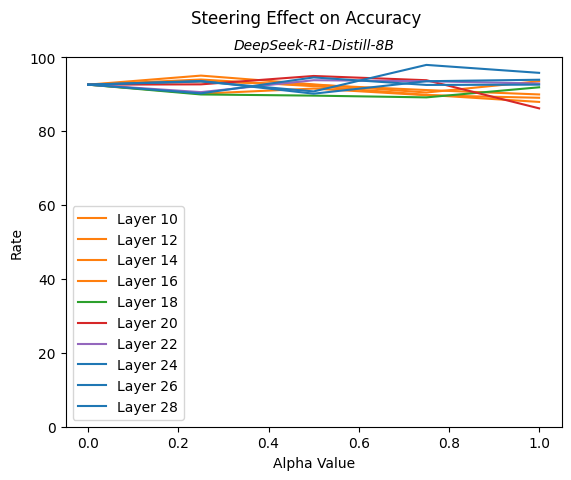

In [26]:
# Generate plot
x = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.suptitle("Steering Effect on Accuracy")
plt.title("DeepSeek-R1-Distill-8B", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.plot(x, [100 * i[0] for i in acc_10], label="Layer 10", color="C1")
plt.plot(x, [100 * i[0] for i in acc_12], label="Layer 12", color="C1")
plt.plot(x, [100 * i[0] for i in acc_14], label="Layer 14", color="C1")
plt.plot(x, [100 * i[0] for i in acc_16], label="Layer 16", color="C1")
plt.plot(x, [100 * i[0] for i in acc_18], label="Layer 18", color="C2")
plt.plot(x, [100 * i[0] for i in acc_20], label="Layer 20", color="C3")
plt.plot(x, [100 * i[0] for i in acc_22], label="Layer 22", color="C4")
plt.plot(x, [100 * i[0] for i in acc_24], label="Layer 24", color="C0")
plt.plot(x, [100 * i[0] for i in acc_26], label="Layer 26", color="C0")
plt.plot(x, [100 * i[0] for i in acc_28], label="Layer 28", color="C0")
plt.ylim(0, 100)
plt.legend();
# plt.savefig("steering_accuracy_results.png", dpi=300);

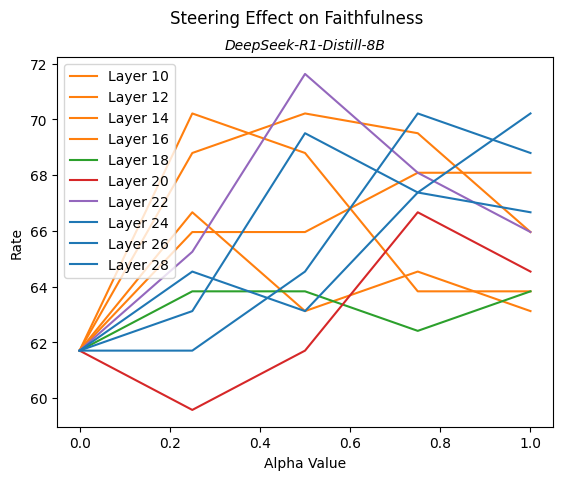

In [27]:
# Generate plot
x = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.suptitle("Steering Effect on Faithfulness")
plt.title("DeepSeek-R1-Distill-8B", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.plot(x, [100 * i for i in ff_10], label="Layer 10", color="C1")
plt.plot(x, [100 * i for i in ff_12], label="Layer 12", color="C1")
plt.plot(x, [100 * i for i in ff_14], label="Layer 14", color="C1")
plt.plot(x, [100 * i for i in ff_16], label="Layer 16", color="C1")
plt.plot(x, [100 * i for i in ff_18], label="Layer 18", color="C2")
plt.plot(x, [100 * i for i in ff_20], label="Layer 20", color="C3")
plt.plot(x, [100 * i for i in ff_22], label="Layer 22", color="C4")
plt.plot(x, [100 * i for i in ff_24], label="Layer 24", color="C0")
plt.plot(x, [100 * i for i in ff_26], label="Layer 26", color="C0")
plt.plot(x, [100 * i for i in ff_28], label="Layer 28", color="C0")
plt.legend();
# plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

In [28]:
[100 * i for i in ff_22]

[61.702127659574465,
 65.24822695035462,
 71.63120567375887,
 68.08510638297872,
 65.95744680851064]